In [3]:
import os
import pickle
import time
import warnings
from copy import deepcopy
from datetime import datetime
from functools import partial
from itertools import repeat
from types import SimpleNamespace
from typing import Callable
import copy

import bayes_opt as bayes
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bayes_opt import (
    BayesianOptimization,
    SequentialDomainReductionTransformer,
    UtilityFunction,
)
from bayes_opt.event import Events
from bayes_opt.logger import JSONLogger
from bayes_opt.util import load_logs
from library.classes import Feature, ManageDataSplit, ManageFeatures, feature_objects
from library.classes.trait import DataFrame
from library.feature_func import (
    add_categorical_feature,
    add_feature_targets_groupby_stats,
    add_numerical_feature,
    f_rolling_mean,
    f_shifted,
    time_arrow,
    f_microbusiness_pct_change,
    f_microbusiness_density_diff,
)
from library.optimize_this import optimize_this
from library.utils import build_callbacks, read_df, smape, states, states_abb, write_df
from meteostat import Monthly, Point, Stations
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from traitlets import (
    Any,
    Bool,
    Callable,
    Dict,
    Float,
    HasTraits,
    Int,
    List,
    TraitError,
    TraitType,
    Tuple,
    Unicode,
    default,
    validate,
)

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 500)

In [4]:
# df_census = read_df("census_starter.csv")
df_test = read_df("test.csv")
df_train = read_df("train.csv")
df_submission = read_df("sample_submission.csv")
# df_population = read_df('df_population.csv', 'other')
# df_census_population = read_df('df_census_population.csv', 'kaggle_census')
# df_train_census = read_df('df_train_census.csv', 'kaggle_census')
df_adjusted_microbusiness_density = read_df('df_adjusted_microbusiness_density.csv', 'kaggle_census')

# df_boundaries = read_df("us-county-boundaries.csv", boundaries_sub_data_path, delimiter=";")
df_train = pd.merge(df_train, df_adjusted_microbusiness_density, 'left', 'row_id')
df_train = df_train.rename(
    columns={
        "microbusiness_density": "original_microbusiness_density",
        "adjusted_microbusiness_density": "microbusiness_density",
    }
)

# df_train = df_train.rename(
#     columns={
#         "microbusiness_density": "original_microbusiness_density",
#         "active": "microbusiness_density",
#     }
# )
df_location = read_df('cfips_location.csv', 'usa-counties-coordinates')

### Indicators

In [112]:
df_weekly_earnings_raw = read_df('weekly_earnings_raw.csv', 'us-indicator')

In [117]:
t2 = df_weekly_earnings_raw.set_index('Geography').T
t2

Geography,United States,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
2007-01-01,1028.428819,1021.244084,1275.114492,1037.079826,785.174223,1244.161482,1136.317144,1289.205371,1083.106118,1724.277726,1043.091543,1029.983068,984.059415,791.831100,1124.367024,1022.769007,894.191578,957.915778,956.684109,914.206197,926.713501,1210.554517,1246.111624,1093.809907,1160.715918,859.719513,979.719249,840.232753,966.302856,1067.358352,1068.047500,1283.604210,925.071275,1256.580809,970.965603,878.062581,986.332138,885.305967,1015.320344,983.868800,1081.024011,996.288127,786.273927,968.986135,1108.721897,1102.930121,974.088763,1141.229157,1233.003148,888.766370,957.021352,994.880506
2007-02-01,1029.941697,1018.448961,1276.175033,1037.073611,796.076180,1227.301734,1149.084037,1286.865611,1089.855607,1751.577615,1055.231551,1024.632870,969.940279,785.779388,1132.720014,1001.005671,909.238796,973.673960,961.262388,923.108837,922.758804,1205.483036,1265.732394,1084.444687,1164.354208,854.823314,987.894034,835.877801,958.739237,1071.435143,1064.142797,1251.366474,929.759456,1252.066539,974.826151,865.703494,984.145768,878.538022,1026.470541,968.846427,1096.229117,1003.893439,798.599331,977.991029,1109.676202,1152.569778,969.809017,1136.176585,1241.798916,851.308404,956.930735,1028.570736
2007-03-01,1025.663208,1026.226878,1283.679689,1022.584701,786.421285,1227.832967,1149.352713,1272.912140,1070.034180,1741.625701,1029.059683,1047.675257,954.597387,779.917396,1126.328948,1016.933544,886.335464,942.818122,945.463037,928.870895,929.246675,1203.696314,1242.314958,1085.802496,1129.075034,853.093368,982.939887,824.823133,955.363400,1065.958410,1058.052572,1222.745481,908.318607,1237.892314,980.280520,856.489843,991.684004,854.538676,1009.764814,966.434464,1084.501719,987.478156,799.400155,970.900467,1102.380185,1110.488366,1002.393740,1125.851996,1215.128705,854.697660,965.755169,1018.797992
2007-04-01,1039.879409,1032.038957,1278.524955,1027.860255,823.003322,1242.223376,1160.846380,1298.829715,1098.697157,1827.600698,1036.490496,1027.860255,988.399519,802.052371,1153.924955,1023.753352,871.008139,972.776055,944.559044,962.235960,931.247508,1208.793758,1272.867194,1087.898586,1159.065764,849.626395,983.761303,852.756831,979.941596,1048.983523,1071.126338,1227.418421,936.977069,1248.900684,974.527951,873.707782,1001.366420,873.837020,1037.926476,981.837090,1064.276712,985.455760,833.945491,967.965521,1122.520068,1131.695982,988.657996,1150.665280,1245.612290,870.591705,983.072033,1034.192927
2007-05-01,1016.793304,1017.221482,1260.540529,1003.277165,807.642828,1208.202956,1127.420119,1318.658499,1044.125306,1764.691086,1019.476550,999.894562,947.000358,790.472907,1131.844620,1007.073673,862.092744,966.739345,921.652245,948.341981,922.551418,1181.613128,1244.669413,1068.374430,1100.188024,829.437067,959.274782,1087.513968,951.496223,1021.688801,1054.758383,1202.251287,916.656840,1215.410612,950.397234,859.809130,968.594781,848.790693,988.976034,965.269268,1047.322366,964.313005,769.549296,944.003115,1087.585331,1090.611119,984.094809,1118.656751,1181.912852,856.797614,951.510495,1008.372478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,1111.865130,993.996523,1210.443049,1066.599657,891.590530,1293.067319,1138.260803,1169.155967,994.447474,1727.704049,1011.934358,1032.908596,1118.238573,935.954101,1116.063986,1005.150048,963.802839,982.4

<Axes: >

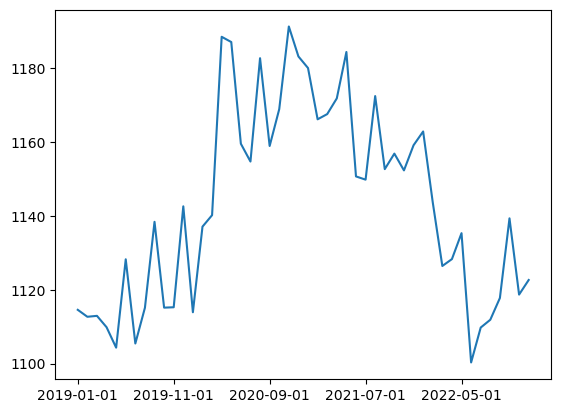

In [122]:
t2['United States'].loc['2019-01-01':].plot()

### Reduce feature space

In [93]:
from sklearn.decomposition import PCA

In [105]:
import numpy as np
from sklearn.decomposition import PCA
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=1)
pca.fit(X)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

[0.99244289]
[6.30061232]


In [101]:
df_train

,row_id,cfips,county,state,first_day_of_month,original_microbusiness_density,active,state_abb,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month,microbusiness_density,target_census_over_18_population_x1000,target_census_population_x1000
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,AL,2019,55317.0,76.6,14.5,2.1,1.3,8,2.810658,44.438,58.239
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,AL,2019,55317.0,76.6,14.5,2.1,1.3,9,2.695891,44.438,58.239
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,AL,2019,55317.0,76.6,14.5,2.1,1.3,10,2.855664,44.438,58.239
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,AL,2019,55317.0,76.6,14.5,2.1,1.3,11,2.797156,44.438,58.239
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,AL,2019,55317.0,76.6,14.5,2.1,1.3,12,2.797156,44.438,58.239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128530,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100,WY,2022,53333.0,79.7,12.7,2.3,0.0,8,1.818512,5.499,6.891
128531,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100,WY,2022,53333.0,79.7,12.7,2.3,0.0,9,1.818512,5.499,6.891
128532,56045_2022-10-01,56045,Weston County,Wyoming,2022-10-01,1.785395,100,WY,2022,53333.0,79.7,12.7,2.3,0.0,10,1.818512,5.499,6.891
128533,56045_2022-11-01,56045,Weston County,Wyoming,2022-11-01,1.785395,100,WY,2022,53333.0,79.7,12.7,2.3,0.0,11,1.818512,5.499,6.891


In [106]:
pca_res = pca.fit_transform(df_train[['median_hh_inc', 'pct_bb', 'pct_college', 'pct_foreign_born', 'pct_it_workers']].dropna())

In [107]:
pca_res

array([[2376.80587616],
       [2376.80587616],
       [2376.80587616],
       ...,
       [ 392.80719724],
       [ 392.80719724],
       [ 392.80719724]])

In [108]:
print(pca.explained_variance_ratio_)

# print(pca.singular_values_)

[0.99999957]


### Remove outliers

In [65]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)

    percentile_.__name__ = "percentile_%s" % n
    return percentile_


f_col = "microbusiness_density_diff"

df = df_train.copy()
df[f_col] = df["microbusiness_density"].shift(1) - df["microbusiness_density"].shift(2)


df.groupby(["cfips"])["microbusiness_density"].agg(
    [min, max, "mean", percentile(95), percentile(5)]
)

,min,max,mean,percentile_95,percentile_5
cfips,,,,,
1001,2.695891,3.319231,3.011870,3.292227,2.761150
1003,6.436653,8.245698,7.364729,8.166531,6.602285
1005,1.000250,1.240310,1.116987,1.220305,1.015254
1007,1.191011,1.348315,1.274322,1.325843,1.213483
1009,1.502179,1.818544,1.650298,1.803057,1.506604
...,...,...,...,...,...
56037,2.728946,3.592054,3.170561,3.538110,2.859047
56039,24.779592,26.934112,25.865568,26.725442,25.082164
56041,3.333106,4.603511,3.922163,4.446418,3.394577


In [92]:
df_train["microbusiness_density"].quantile(0.01)

0.5013497878904744

In [85]:
df_train[
    df_train["microbusiness_density"].quantile(0.001)
    < df_train["microbusiness_density"]
]

,row_id,cfips,county,state,first_day_of_month,original_microbusiness_density,active,state_abb,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month,microbusiness_density,target_census_over_18_population_x1000,target_census_population_x1000
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,AL,2019,55317.0,76.6,14.5,2.1,1.3,8,2.810658,44.438,58.239
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,AL,2019,55317.0,76.6,14.5,2.1,1.3,9,2.695891,44.438,58.239
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,AL,2019,55317.0,76.6,14.5,2.1,1.3,10,2.855664,44.438,58.239
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,AL,2019,55317.0,76.6,14.5,2.1,1.3,11,2.797156,44.438,58.239
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,AL,2019,55317.0,76.6,14.5,2.1,1.3,12,2.797156,44.438,58.239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128530,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100,WY,2022,53333.0,79.7,12.7,2.3,0.0,8,1.818512,5.499,6.891
128531,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100,WY,2022,53333.0,79.7,12.7,2.3,0.0,9,1.818512,5.499,6.891
128532,56045_2022-10-01,56045,Weston County,Wyoming,2022-10-01,1.785395,100,WY,2022,53333.0,79.7,12.7,2.3,0.0,10,1.818512,5.499,6.891
128533,56045_2022-11-01,56045,Weston County,Wyoming,2022-11-01,1.785395,100,WY,2022,53333.0,79.7,12.7,2.3,0.0,11,1.818512,5.499,6.891


In [81]:
df_train[
    df_train["microbusiness_density"].quantile(0.001)
    < df_train["microbusiness_density"]
]

,row_id,cfips,county,state,first_day_of_month,original_microbusiness_density,active,state_abb,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month,microbusiness_density,target_census_over_18_population_x1000,target_census_population_x1000
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,AL,2019,55317.0,76.6,14.5,2.1,1.3,8,2.810658,44.438,58.239
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,AL,2019,55317.0,76.6,14.5,2.1,1.3,9,2.695891,44.438,58.239
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,AL,2019,55317.0,76.6,14.5,2.1,1.3,10,2.855664,44.438,58.239
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,AL,2019,55317.0,76.6,14.5,2.1,1.3,11,2.797156,44.438,58.239
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,AL,2019,55317.0,76.6,14.5,2.1,1.3,12,2.797156,44.438,58.239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128530,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100,WY,2022,53333.0,79.7,12.7,2.3,0.0,8,1.818512,5.499,6.891
128531,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100,WY,2022,53333.0,79.7,12.7,2.3,0.0,9,1.818512,5.499,6.891
128532,56045_2022-10-01,56045,Weston County,Wyoming,2022-10-01,1.785395,100,WY,2022,53333.0,79.7,12.7,2.3,0.0,10,1.818512,5.499,6.891
128533,56045_2022-11-01,56045,Weston County,Wyoming,2022-11-01,1.785395,100,WY,2022,53333.0,79.7,12.7,2.3,0.0,11,1.818512,5.499,6.891


In [78]:
df_train[
    df_train["microbusiness_density"].quantile(0.99)
    > df_train["microbusiness_density"]
]

,row_id,cfips,county,state,first_day_of_month,original_microbusiness_density,active,state_abb,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month,microbusiness_density,target_census_over_18_population_x1000,target_census_population_x1000
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,AL,2019,55317.0,76.6,14.5,2.1,1.3,8,2.810658,44.438,58.239
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,AL,2019,55317.0,76.6,14.5,2.1,1.3,9,2.695891,44.438,58.239
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,AL,2019,55317.0,76.6,14.5,2.1,1.3,10,2.855664,44.438,58.239
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,AL,2019,55317.0,76.6,14.5,2.1,1.3,11,2.797156,44.438,58.239
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,AL,2019,55317.0,76.6,14.5,2.1,1.3,12,2.797156,44.438,58.239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128530,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100,WY,2022,53333.0,79.7,12.7,2.3,0.0,8,1.818512,5.499,6.891
128531,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100,WY,2022,53333.0,79.7,12.7,2.3,0.0,9,1.818512,5.499,6.891
128532,56045_2022-10-01,56045,Weston County,Wyoming,2022-10-01,1.785395,100,WY,2022,53333.0,79.7,12.7,2.3,0.0,10,1.818512,5.499,6.891
128533,56045_2022-11-01,56045,Weston County,Wyoming,2022-11-01,1.785395,100,WY,2022,53333.0,79.7,12.7,2.3,0.0,11,1.818512,5.499,6.891


In [70]:
df_train[['microbusiness_density']].quantile(0.99)

microbusiness_density    18.401041
Name: 0.99, dtype: float64

### Economical indicators

In [16]:
os.listdir('../data/us-indicator/')

['accommodation_and_food_services_state_gdp_raw_in_millions.csv',
 'accommodation_and_food_services_state_gdp_yoy_percent_change.csv',
 'co-est2021-alldata.csv',
 'federal_public_employment_raw_in_thousands.csv',
 'federal_public_employment_yoy_percent_change.csv',
 'government_state_gdp_raw_in_millions.csv',
 'government_state_gdp_yoy_percent_change.csv',
 'house_price_index_yoy_percent_change.csv',
 'manufacturing_employment_raw_in_thousands.csv',
 'manufacturing_employment_yoy_percent_change.csv',
 'manufacturing_state_gdp_raw_in_millions.csv',
 'manufacturing_state_gdp_yoy_percent_change.csv',
 'private_employment_raw_in_thousands.csv',
 'private_employment_yoy_percent_change.csv',
 'public_employment_raw_in_thousands.csv',
 'public_employment_yoy_percent_change.csv',
 'retail_trade_employment_raw_in_thousands.csv',
 'retail_trade_employment_yoy_percent_change.csv',
 'retail_trade_state_gdp_raw_in_millions.csv',
 'retail_trade_state_gdp_yoy_percent_change.csv',
 'sem_earnings_data_

### Groupby cfips

In [21]:
t1 = df_train.pivot_table('original_microbusiness_density', 'first_day_of_month', 'cfips')

In [44]:
t2 = t1.corr().rename_axis('cfips_x').rename_axis('cfips_y', axis=1)
t3 = t2.stack().rename('corr').reset_index()
t3 = t3[(t3['cfips_x'] != t3['cfips_y'])]
t3 = t3.sort_values('corr')

In [61]:
t3.head(3)

,cfips_x,cfips_y,corr
1246347,13025,32017,-0.998352
5492917,32017,13025,-0.998352
2517802,19033,13025,-0.998047


In [48]:
t1[[48051, 51710]]

cfips,48051,51710
first_day_of_month,,
2019-08-01,3.264226,4.193869
2019-09-01,3.146596,4.112454
2019-10-01,3.183355,4.092609
2019-11-01,3.249522,4.089047
2019-12-01,3.198059,4.058516
2020-01-01,3.173916,4.031139
2020-02-01,3.173916,4.004208
2020-03-01,3.137849,4.063153
2020-04-01,3.202770,4.103805


In [49]:
def df_shifted(df, target=None, lag=0):
    if not lag and not target:
        return df       
    new = {}
    for c in df.columns:
        if c == target:
            new[c] = df[target]
        else:
            new[c] = df[c].shift(periods=lag)
    return  pd.DataFrame(data=new)

In [63]:
t2

cfips_y,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,1021,1023,1025,1027,1029,1031,1033,1035,1037,1039,1041,1043,1045,1047,1049,1051,1053,1055,1057,1059,1061,1063,1065,1067,1069,1071,1073,1075,1077,1079,1081,1083,1085,1087,1089,1091,1093,1095,1097,1099,1101,1103,1105,1107,1109,1111,1113,1115,1117,1119,1121,1123,1125,1127,1129,1131,1133,2013,2016,2020,2050,2060,2068,2070,2090,2100,2105,2110,2122,2130,2150,2164,2170,2180,2185,2188,2195,2198,2220,2230,2240,2275,2282,2290,4001,4003,4005,4007,4009,4011,4012,4013,4015,4017,4019,4021,4023,4025,4027,5001,5003,5005,5007,5009,5011,5013,5015,5017,5019,5021,5023,5025,5027,5029,5031,5033,5035,5037,5039,5041,5043,5045,5047,5049,5051,5053,5055,5057,5059,5061,5063,5065,5067,5069,5071,5073,5075,5077,5079,5081,5083,5085,5087,5089,5091,5093,5095,5097,5099,5101,5103,5105,5107,5109,5111,5113,5115,5117,5119,5121,5123,5125,5127,5129,5131,5133,5135,5137,5139,5141,5143,5145,5147,5149,6001,6003,6005,6007,6009,6011,6013,6015,6017,6019,6021,6023,6025,6027,6029,6031,6033,6035,6037,6039,6041,6043,6045,6047,6049,6051,6053,6055,6057,6059,6061,6063,6065,6067,6069,6071,6073,6075,6077,6079,6081,6083,6085,6087,6089,6091,6093,6095,6097,6099,6101,6103,6105,6107,6109,6111,6113,6115,8001,8003,8005,8007,8009,8011,8013,8014,...,51145,51147,51149,51153,51155,51157,51159,51161,51163,51165,51167,51169,51171,51173,51175,51177,51179,51181,51183,51185,51187,51191,51193,51195,51197,51199,51510,51520,51530,51540,51550,51570,51590,51595,51600,51610,51620,51630,51650,51660,51670,51678,51680,51683,51685,51700,51710,51720,51730,51735,51740,51750,51760,51770,51775,51790,51800,51810,51820,51830,51840,53001,53003,53005,53007,53009,53011,53013,53015,53017,53019,53021,53023,53025,53027,53029,53031,53033,53035,53037,53039,53041,53043,53045,53047,53049,53051,53053,53055,53057,53059,53061,53063,53065,53067,53069,53071,53073,53075,53077,54001,54003,54005,54007,54009,54011,54013,54015,54017,54019,54021,54023,54025,54027,54029,54031,54033,54035,54037,54039,54041,54043,54045,54047,54049,54051,54053,54055,54057,54059,54061,54063,54065,54067,54069,54071,54073,54075,54077,54079,54081,54083,54085,54087,54089,54091,54093,54095,54097,54099,54101,54103,54105,54107,54109,55001,55003,55005,55007,55009,55011,55013,55015,55017,55019,55021,55023,55025,55027,55029,55031,55033,55035,55037,55039,55041,55043,55045,55047,55049,55051,55053,55055,55057,55059,55061,55063,55065,55067,55069,55071,55073,55075,55077,55078,55079,55081,55083,55085,55087,55089,55091,55093,55095,55097,55099,55101,55103,55105,55107,55109,55111,55113,55115,55117,55119,55121,55123,55125,55127,55129,55131,55133,55135,55137,55139,55141,56001,56003,56005,56007,56009,56011,56013,56015,56017,56019,56021,56023,56025,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
cfips_x,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001,1.000000,0.735965,0.836279,-0.111430,0.950463,-0.139521,0.836494,-0.131926,0.616428,0.357660,0.930483,0.940128,0.641340,0.524098,0.781343,0.658561,0.452920,0.421286,0.886832,0.912821,0.463132,0.909046,0.872330,0.923795,0.830643,0.851140,0.690556,0.876963,-0.776034,0.867467,0.924212,0.509432,0.916272,-0.728358,-0.083690,0.777676,0.906820,0.709102,-0.742973,0.860287,0.337330,0.600747,0.821709,0.333263,0.851335,-0.712668,0.810016,0.704687,0.696600,0.480945,0.178736,0.754939,0.509789,0.814896,0.887834,0.901738,0.707348,0.202285,-0.241315,0.352012,0.870676,0.519604,-0.746817,0.491702,0.798105,0.519662,0.647150,-0.782230,-0.676927,0.287320,0.760231,-0.361306,-0.425475,-0.338566,-0.712565,-0.725387,-0.759542,-0.222477,0.6

In [59]:
df_shifted(t1, target='1001', lag=-1).corr()

,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,1021,1023,1025,1027,1029,1031,1033,1035,1037,1039,1041,1043,1045,1047,1049,1051,1053,1055,1057,1059,1061,1063,1065,1067,1069,1071,1073,1075,1077,1079,1081,1083,1085,1087,1089,1091,1093,1095,1097,1099,1101,1103,1105,1107,1109,1111,1113,1115,1117,1119,1121,1123,1125,1127,1129,1131,1133,2013,2016,2020,2050,2060,2068,2070,2090,2100,2105,2110,2122,2130,2150,2164,2170,2180,2185,2188,2195,2198,2220,2230,2240,2275,2282,2290,4001,4003,4005,4007,4009,4011,4012,4013,4015,4017,4019,4021,4023,4025,4027,5001,5003,5005,5007,5009,5011,5013,5015,5017,5019,5021,5023,5025,5027,5029,5031,5033,5035,5037,5039,5041,5043,5045,5047,5049,5051,5053,5055,5057,5059,5061,5063,5065,5067,5069,5071,5073,5075,5077,5079,5081,5083,5085,5087,5089,5091,5093,5095,5097,5099,5101,5103,5105,5107,5109,5111,5113,5115,5117,5119,5121,5123,5125,5127,5129,5131,5133,5135,5137,5139,5141,5143,5145,5147,5149,6001,6003,6005,6007,6009,6011,6013,6015,6017,6019,6021,6023,6025,6027,6029,6031,6033,6035,6037,6039,6041,6043,6045,6047,6049,6051,6053,6055,6057,6059,6061,6063,6065,6067,6069,6071,6073,6075,6077,6079,6081,6083,6085,6087,6089,6091,6093,6095,6097,6099,6101,6103,6105,6107,6109,6111,6113,6115,8001,8003,8005,8007,8009,8011,8013,8014,...,51145,51147,51149,51153,51155,51157,51159,51161,51163,51165,51167,51169,51171,51173,51175,51177,51179,51181,51183,51185,51187,51191,51193,51195,51197,51199,51510,51520,51530,51540,51550,51570,51590,51595,51600,51610,51620,51630,51650,51660,51670,51678,51680,51683,51685,51700,51710,51720,51730,51735,51740,51750,51760,51770,51775,51790,51800,51810,51820,51830,51840,53001,53003,53005,53007,53009,53011,53013,53015,53017,53019,53021,53023,53025,53027,53029,53031,53033,53035,53037,53039,53041,53043,53045,53047,53049,53051,53053,53055,53057,53059,53061,53063,53065,53067,53069,53071,53073,53075,53077,54001,54003,54005,54007,54009,54011,54013,54015,54017,54019,54021,54023,54025,54027,54029,54031,54033,54035,54037,54039,54041,54043,54045,54047,54049,54051,54053,54055,54057,54059,54061,54063,54065,54067,54069,54071,54073,54075,54077,54079,54081,54083,54085,54087,54089,54091,54093,54095,54097,54099,54101,54103,54105,54107,54109,55001,55003,55005,55007,55009,55011,55013,55015,55017,55019,55021,55023,55025,55027,55029,55031,55033,55035,55037,55039,55041,55043,55045,55047,55049,55051,55053,55055,55057,55059,55061,55063,55065,55067,55069,55071,55073,55075,55077,55078,55079,55081,55083,55085,55087,55089,55091,55093,55095,55097,55099,55101,55103,55105,55107,55109,55111,55113,55115,55117,55119,55121,55123,55125,55127,55129,55131,55133,55135,55137,55139,55141,56001,56003,56005,56007,56009,56011,56013,56015,56017,56019,56021,56023,56025,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
1001,1.000000,0.730315,0.837690,-0.087928,0.950816,-0.139309,0.832574,-0.155834,0.677080,0.342827,0.928653,0.940632,0.666592,0.506218,0.778811,0.653603,0.462297,0.408662,0.884232,0.915555,0.446756,0.909702,0.868803,0.923484,0.825880,0.847002,0.685043,0.877038,-0.771655,0.885695,0.930297,0.522249,0.914218,-0.723465,-0.115926,0.774414,0.906100,0.709230,-0.781846,0.864470,0.372470,0.609880,0.816863,0.307871,0.847135,-0.706755,0.804615,0.698447,0.806585,0.461564,0.186391,0.748046,0.492782,0.809565,0.892849,0.899106,0.698189,0.199958,-0.241180,0.327859,0.867140,0.546358,-0.743114,0.481035,0.805408,0.502993,0.644624,-0.785880,-0.667117,0.607601,0.767109,-0.336452,-0.440091,-0.331814,-0.703553,-0.737752,-0.760328,-0.293736,0.632733,0.783395,-0.609186,0.812986,0.858186,-0.503683,-0.635372,-0.437315,0.759786,0.631704,-0.209000,-0.827840,0.784085,0.790272,0.837396,0.808457,-0.610291,0.686608,-0.262366,-0.077595,0.471683,0.166868,-0.292274,0.596253,0.428324,0.605086,0.512378,0.481256,0.782175,-0.179329,0.775175,0.819385,-0.736797,0.605350,0.531103,0.517947,0.216255,-0.765671,0.870131,0.823176,0.572953,-0.449137,0.925005,-0.500817,0.918553,0.864335,0.465383,0.873795,-0.736380,0.924058,0.841874,-0.249670,0.306611,0.178418,0.832321,0.91322

### Location feature

In [7]:
# coordinates = raw[['lng', 'lat']].values

# # Encoding tricks
# emb_size = 20
# precision = 1e6

# latlon = np.expand_dims(coordinates, axis=-1)

# m = np.exp(np.log(precision)/emb_size)
# angle_freq = m ** np.arange(emb_size)
# angle_freq = angle_freq.reshape(1,1, emb_size)
# latlon = latlon * angle_freq
# latlon[..., 0::2] = np.cos(latlon[..., 0::2])

In [11]:
def rot(df):
    for angle in [15, 30, 45]:
        df[f'rot_{angle}_x'] = (np.cos(np.radians(angle)) * df['lat']) + \
                                (np.sin(np.radians(angle)) * df['lng'])
        
        df[f'rot_{angle}_y'] = (np.cos(np.radians(angle)) * df['lat']) - \
                                (np.sin(np.radians(angle)) * df['lng'])
        
    return df

f_location = rot(df_location)

In [13]:
t4 = pd.merge(df_train, f_location, 'left', 'cfips')
t4

,row_id,cfips,county,state,first_day_of_month,original_microbusiness_density,active,state_abb,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month,microbusiness_density,target_census_over_18_population_x1000,target_census_population_x1000,name,lng,lat,rot_15_x,rot_15_y,rot_30_x,rot_30_y,rot_45_x,rot_45_y
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,AL,2019,55317.0,76.6,14.5,2.1,1.3,8,2.810658,44.438,58.239,Autauga,-86.642900,32.535142,9.001702,53.851367,-15.145190,71.497710,-38.259962,84.271602
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,AL,2019,55317.0,76.6,14.5,2.1,1.3,9,2.695891,44.438,58.239,Autauga,-86.642900,32.535142,9.001702,53.851367,-15.145190,71.497710,-38.259962,84.271602
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,AL,2019,55317.0,76.6,14.5,2.1,1.3,10,2.855664,44.438,58.239,Autauga,-86.642900,32.535142,9.001702,53.851367,-15.145190,71.497710,-38.259962,84.271602
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,AL,2019,55317.0,76.6,14.5,2.1,1.3,11,2.797156,44.438,58.239,Autauga,-86.642900,32.535142,9.001702,53.851367,-15.145190,71.497710,-38.259962,84.271602
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,AL,2019,55317.0,76.6,14.5,2.1,1.3,12,2.797156,44.438,58.239,Autauga,-86.642900,32.535142,9.001702,53.851367,-15.145190,71.497710,-38.259962,84.271602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128530,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100,WY,2022,53333.0,79.7,12.7,2.3,0.0,8,1.818512,5.499,6.891,Weston,-104.567404,43.840315,15.282457,69.410528,-14.316875,90.250528,-42.940536,104.940104
128531,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100,WY,2022,53333.0,79.7,12.7,2.3,0.0,9,1.818512,5.499,6.891,Weston,-104.567404,43.840315,15.282457,69.410528,-14.316875,90.250528,-42.940536,104.940104
128532,56045_2022-10-01,56045,Weston County,Wyoming,2022-10-01,1.785395,100,WY,2022,53333.0,79.7,12.7,2.3,0.0,10,1.818512,5.499,6.891,Weston,-104.567404,43.840315,15.282457,69.410528,-14.316875,90.250528,-42.940536,104.940104
128533,56045_2022-11-01,56045,Weston County,Wyoming,2022-11-01,1.785395,100,WY,2022,53333.0,79.7,12.7,2.3,0.0,11,1.818512,5.499,6.891,Weston,-104.567404,43.840315,15.282457,69.410528,-14.316875,90.250528,-42.940536,104.940104


In [15]:
t4.columns

Index(['row_id', 'cfips', 'county', 'state', 'first_day_of_month',
       'original_microbusiness_density', 'active', 'state_abb', 'year',
       'median_hh_inc', 'pct_bb', 'pct_college', 'pct_foreign_born',
       'pct_it_workers', 'month', 'microbusiness_density',
       'target_census_over_18_population_x1000',
       'target_census_population_x1000', 'name', 'lng', 'lat', 'rot_15_x',
       'rot_15_y', 'rot_30_x', 'rot_30_y', 'rot_45_x', 'rot_45_y'],
      dtype='object')

In [14]:
t4[t4['rot_15_y'].isna()]

,row_id,cfips,county,state,first_day_of_month,original_microbusiness_density,active,state_abb,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month,microbusiness_density,target_census_over_18_population_x1000,target_census_population_x1000,name,lng,lat,rot_15_x,rot_15_y,rot_30_x,rot_30_y,rot_45_x,rot_45_y


In [10]:
df_train

,row_id,cfips,county,state,first_day_of_month,original_microbusiness_density,active,state_abb,year,median_hh_inc,pct_bb,pct_college,pct_foreign_born,pct_it_workers,month,microbusiness_density,target_census_over_18_population_x1000,target_census_population_x1000
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,AL,2019,55317.0,76.6,14.5,2.1,1.3,8,2.810658,44.438,58.239
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,AL,2019,55317.0,76.6,14.5,2.1,1.3,9,2.695891,44.438,58.239
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,AL,2019,55317.0,76.6,14.5,2.1,1.3,10,2.855664,44.438,58.239
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,AL,2019,55317.0,76.6,14.5,2.1,1.3,11,2.797156,44.438,58.239
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,AL,2019,55317.0,76.6,14.5,2.1,1.3,12,2.797156,44.438,58.239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128530,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100,WY,2022,53333.0,79.7,12.7,2.3,0.0,8,1.818512,5.499,6.891
128531,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100,WY,2022,53333.0,79.7,12.7,2.3,0.0,9,1.818512,5.499,6.891
128532,56045_2022-10-01,56045,Weston County,Wyoming,2022-10-01,1.785395,100,WY,2022,53333.0,79.7,12.7,2.3,0.0,10,1.818512,5.499,6.891
128533,56045_2022-11-01,56045,Weston County,Wyoming,2022-11-01,1.785395,100,WY,2022,53333.0,79.7,12.7,2.3,0.0,11,1.818512,5.499,6.891


<Axes: xlabel='first_day_of_month'>

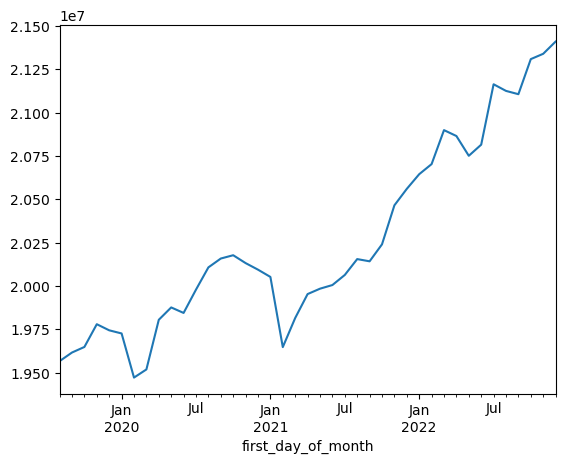

In [111]:
df_train.groupby('first_day_of_month')['active'].sum().plot()

# One column